# An Overview of Nearest Neighbors Search

Nearest neighbors search is an important problem in computer science, with applications ranging from recommender systems to DNA sequencing and cluster analysis. This notebook presents an overview of the problem and of some of the methods developed to solve it.

## Outline

1. Background
    1. Boolean Logic and its Limits
    2. k-NN: Formal Definition
    3. Representations and Metrics
        1. Sequences
        2. Vectors
2. Data Structures and Algorithms
3. NNS in practice: Wikipedia Search
    1. Data Import
    2. n-grams and Vectorization
    3. Brute Force Approach
    4. HNSW Approach
    5. Addendum: Ranking
4. References

## Imports

In [1]:
import matplotlib.pyplot as plt
import nmslib
import numpy as np
import pandas as pd
import requests
from collections import Counter
from matplotlib_inline.backend_inline import set_matplotlib_formats
from scipy.spatial import distance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors

set_matplotlib_formats("retina")

## Background

Database systems design revolves around **sets** and **relations**. Queries are thus often declared as Boolean expressions, i.e. statements that can be evaluated as true or false. Data exists or doesn't exist, and is related to another piece of data or isn't. The limit of this approach is that only information with low entropy can be reasonably modelled in this logic.

An extension to this logic is to specify the spatial structure of a set by defining a **metric**, also known as a **distance function**. By doing so, the elements of the set can be compared and related based on their relative distance. The nearest neighbors search problem arises from this extension. Essentially, it consists in finding the elements in the set that are nearest to a given element.

### Boolean Logic and its Limits

Boolean logic, more commonly known as **propositional logic**, is a binary (two-valued; TRUE/FALSE) system of logic. The three basic Boolean operations are conjunction (`AND`, $\land$), disjunction (`OR`, $\lor$), and negation (`NOT`, $\lnot$).

*Reminder*: The order of operations, from highest to lowest priority is `NOT`, then `AND`, then `OR`.

All other operations can be built by composing these three basic operations. **Logical equality** ($\leftrightarrow$ or $=$), for example, can be expressed in the forms:

$(x = y) = (x \land y) \lor (\lnot x \land \lnot y)$

`x AND y OR NOT x and NOT y`.

The digital logic gate corresponding to logical equality is known as **XNOR**.

In [2]:
xnor = lambda a, b: (a and b) or (not a and not b)
xnor(True, False)

False

In [3]:
xnor(False, False)

True

In Python, the symbol for the equality operation is `==`. The operation is defined for all types, but for some types compares the identity of the variables rather than their value ([Python docs: Value comparisons](https://docs.python.org/3/reference/expressions.html#value-comparisons)).

In [4]:
# Logical equality in Python
True == False

False

Strings (`str`) are compared based on their value, defined by the lexicographic order their Unicode code points.

In [5]:
"house" == "mouse"

False

In Python, the representation of strings depends on its character set. For example, if all characters in a string are in ASCII range, the string is encoded using [latin-1][latin-1] (1 byte per character).

For more details, see the blog post [How Python saves memory when storing strings][str mem], the [PEP 393 – Flexible String Representation][PEP 393] specification, and the [unicodeobject.c][unicodeobject.c] file in cpython (particularly lines 1189-1213).

[latin-1]: https://en.wikipedia.org/wiki/ISO/IEC_8859-1
[str mem]:https://rushter.com/blog/python-strings-and-memory/
[PEP 393]: https://peps.python.org/pep-0393/
[unicodeobject.c]: https://github.com/python/cpython/blob/main/Objects/unicodeobject.c

In [6]:
# Binary representation of a string of latin-1 characters
binary = lambda s: " ".join(map("{:08b}".format, bytearray(s, "latin-1")))
binary("house")

'01101000 01101111 01110101 01110011 01100101'

In [7]:
binary("mouse")

'01101101 01101111 01110101 01110011 01100101'

When the `==` operation is executed on two strings, the [`unicode_compare_eq`][unicode_compare_eq] function is called. If the strings do not have the same number of characters or are not of the same kind, `unicode_compare_eq` returns `0` (False). Else, the blocks of memory containing the data of both strings are compared using the `memcmp` function, which is a *builtin* in GCC and Clang. `memcmp` compares these blocks and returns `0` if they are equal. Thus, if `memcmp` returns `0`, `unicode_compare_eq` returns `1` (True).

[unicode_compare_eq]: https://github.com/python/cpython/blob/main/Objects/unicodeobject.c#L10420-L10439

On x86, older compilers such as GCC 4.5.3 translate the `memcmp` function into the `repz cmpsb` assembly instruction. `cmpsb` compares a byte at one address with a byte at another address by subtracting them. `repz` repeats the `cmpsb` operation until the zero flag (ZF) is zero (i.e. the result of the subtraction is not zero) or the count register (CX) is exhausted.

<div align="center">
    <img src="xnor.svg" style="width:calc(1em * 25); margin:20px;" />
    <div style="font-size: 0.85em;">1-bit half-subtract (A - B) circuit with a zero flag</div>
</div>

More recent versions of GCC have optimized implementations of `memcmp` that leverage SIMD and AVX instructions.

As the foundation of digital electronics, Boolean logic is widely used in higher level abstractions such as software. In SQL, for example, predicates are evaluated to binary truth values, i.e. true/false (sometimes complemented by a third value: unknown). Given a `books` table with `author` and `title` columns, the query

```SQL
SELECT title
FROM books
WHERE author="Tennessee Williams";
```

returns the title of all books whose author is Tennessee Williams. For each relation (row) in the table, the query engine tests whether the predicate `author="Tennessee Williams"` is true or false. Such use of Boolean and predicate logic is common for several reasons:

- Ubiquity: Boolean operations are defined on many data types (strings, integers, etc.)
- Performance: Boolean expressions can be efficiently evaluated
- Simplicity and adoption: Boolean logic is straightforward and widely used
- Theory: logic and set theory are part of the foundations of mathematics

However, the complexity that can be expressed with a few Boolean operators is limited. Yet, in the real world, data is often ambiguous, inconsistent or incomplete. Applications which need to deal with uncertainty and inaccuracy include, for example:

- Genomic analysis: compare genomic sequences
- Web search: rank documents on the WWW based on their relevance to a text query

### Formal Definition

The ***k*-nearest neighbor (*k*-NN) search problem** can be defined as follows: given a set of points $X$ in a space $S$ and a query point $\mathbf{q} \in S$, find the *k* nearest points in $X$ to $q$.

$S$ is usually a metric space, i.e. a set with a metric. Sometimes, however, a similarity measure is used instead of the metric.

Imagine a database of book titles. The book titles are strings, or in other words, sequences of symbols taken from an alphabet. A title like "Les Misérables" is an element in the set of all strings $\Sigma^*$ over the alphabet $\Sigma$. If we define a string metric $d$, then $S = (d, \Sigma^*)$ and $X$ is the set of book titles in the database.

As with the book database, a metric can sometimes be defined directly on the data. Types of data for which metrics are readily available include strings, real numbers, and georgraphic coordinates. In other cases, data is transformed into a suitable metric space.

### Representations and Metrics

#### Sequences

Two common metrics for sequences such as strings are the Hamming distance and the Levenshtein distance.

The ***Hamming distance*** is a metric on the set of strings with length $n$. It is the number of positions between two strings at which their corresponding symbols are different.

For example, the Hamming distance between "<span style="color:cyan">h</span>ouse" and "<span style="color:red">m</span>ouse" is 1.

In [8]:
def hamming_distance(x, y):
    assert len(x) == len(y)
    return sum(xi != yi for xi, yi in zip(x, y))

hamming_distance("house", "mouse")

1

The ***Levenshtein distance*** is a metric on the set of all strings. It is the minimum number of single-character edits required to change one string into the other. Unlike the Hamming distance, it is therefore defined for strings of any length and is able to take account of insertions and deletions.

For example, the Levenshtein distance between "kitten" and "sitting" is 3. The <span style="color:cyan">k</span> and <span style="color:cyan">e</span> need to be substituted by an <span style="color:red">s</span> and <span style="color:red">i</span>, and a <span style="color:red">g</span> needs to be inserted at the end:

<span style="color:cyan">k</span>itt<span style="color:cyan">e</span>n<span style="color:cyan">_</span><br><span style="color:red">s</span>itt<span style="color:red">i</span>n<span style="color:red">g</span>

Sequences are defined by the order of their elements. However, for data such as natural language, units such as words matter more than the index of characters in a sequence of text.

One representation for text is the ***bag-of-words model***. It represents text as the bag ([multiset](https://en.wikipedia.org/wiki/Multiset)) of its words.

In [9]:
BoW = lambda s: Counter(s.split())
BoW("the author of the book is Tennessee Williams")

Counter({'the': 2,
         'author': 1,
         'of': 1,
         'book': 1,
         'is': 1,
         'Tennessee': 1,
         'Williams': 1})

The bag-of-words model is a natural vector representation: each word is a dimension. The distance betweeen two elements in the set can be thus defined by a metric such as the cosine distance.

A drawback of the bag-of-words model is that it represents only the frequency of words and does not capture their order in the sequence.

An alternative representation for sequences such as text is the ***n-gram*** model. An n-gram is a contiguous sub-sequence of *n* items from a given sequence. The unit of an n-gram depends on the elements of the given sequence. For text, it can be words or characters, while for a DNA sequence it might be base pairs. For example, the string "language" can be split into 5 character 4-grams:

lang, angu, ngua, guag, uage

In [10]:
def word_ngrams(s: str, n=2):
    """Splits a string into n-grams of n words"""
    words = s.split()
    return [" ".join(words[i:i+n]) for i in range(len(words)-n+1)]

word_ngrams("John likes to watch movies")

['John likes', 'likes to', 'to watch', 'watch movies']

In [11]:
def char_ngrams(s: str, n=3):
    """Splits a string into n-grams of n characters"""
    return [s[i:i+n] for i in range(len(s)-n+1)]

char_ngrams("Apple Inc.")

['App', 'ppl', 'ple', 'le ', 'e I', ' In', 'Inc', 'nc.']

The distance between the sets of n-grams of two sequences can be measured using a metric such as the Jaccard distance. The Jaccard distance is a metric on the set of all finite sets. For two sets $A$ and $B$, the Jaccard similarity coefficient (also known as the Jaccard index) is given by the size of their intersection divided by the size of their union:

$$J(A, B) = \frac{|A \cap B|}{|A \cup B|}$$

The Jaccard distance is then obtained by substracting the similarity coefficient from $1$:

$$d_{Jaccard}(A, B) = 1 - J(A, B)$$

In [12]:
def jaccard(a: set, b: set):
    """Jaccard distance between two sets a and b"""
    coeff = len(a & b) / len(a | b)
    return 1 - coeff

# character 3-grams of two DNA sequences
a = ("ATC", "TCG", "CGA", "GAT")
b = ("CGA", "GAT", "ATT", "TTG", "TGA")
jaccard(set(a), set(b))

0.7142857142857143

In [13]:
jaccard(set(a), set(a))

0.0

Alternatively, a set of n-gram sequences can be vectorized so that the distance between two sequences is measurable using a metric such as the cosine distance.

In [14]:
# Set of n-gram sequences
s = set([a, b])
# Find the set of all n-grams
dims = set.union(*[set(element) for element in s])
# Create a feature matrix
matrix = np.zeros((len(s), len(dims)))
# Populate the matrix
for e_idx, element in enumerate(s):
    features = Counter(element)
    for d_idx, dim in enumerate(dims):
        matrix[e_idx][d_idx] = features.get(dim, 0)

df = pd.DataFrame(matrix, index=["ATCGAT", "CGATTGA"], columns=dims, dtype=int)
df

,ATT,TGA,ATC,CGA,TCG,TTG,GAT
ATCGAT,0,0,1,1,1,0,1
CGATTGA,1,1,0,1,0,1,1


In [15]:
distance.cosine(df.loc["ATCGAT"], df.loc["CGATTGA"])

0.5527864045000421

***Word and sentence embeddings*** are two other representations of text. The idea is to represent words or sentences as low-dimensional vectors using a language model such as a neural network. The language model is typically designed to encode the meaning of the word or sentence. Words or sentences with similar meaning or semantic content will thus be close (e.g. small cosine distance) in the vector space.

#### Vectors

An important subset of metric spaces are normed vector spaces. A vector space is a set of vectors in which two operations are defined: addition and scalar multiplication. Normed vector spaces are vector spaces with a specified norm, i.e. a function which determines the length of all vectors in the vector space. A norm induces a metric, so every normed vector space is a metric space.

The $p$-norm or $L^p$ norm of a vector $x$ is defined by

$${\lVert x \rVert}_p = \left(\sum_{i=1}^n |x_i|^p\right)^{\frac{1}{p}}$$

for a real number $p ≥ 1$. For a given $p$-norm, the corresponding distance (also known as Minkowski distance) between two points $x$ and $y$ is:

$$d(x,y) = {\lVert x-y \rVert}_p$$

Based on $p$, we can distinguish between three metrics:
- $p=1$:    ***Manhattan distance*** / ***taxicab metric***

$$d_{Manhattan}(x, y) = \sum_{i=1}^n|x_i-y_i|$$

In [16]:
def manhattan(x: np.ndarray, y: np.ndarray):
    """Manhattan distance between two points x and y"""
    return np.sum(np.abs(x - y))

x = np.array([0, 0])
y = np.array([2, 1])
manhattan(x, y)

3

The Manhattan distance can be used when the dimensions of the vector space are not comparable. It is faster to compute than the Euclidean distance and may therefore be preferred in very high dimensional spaces.

- $p=2$: ***Euclidean distance***

$$d_{Euclidean}(x, y) = \left(\sum_{i=1}^n (x_i-y_i)^2\right)^{\frac{1}{2}}$$

In [17]:
def euclidean(x: np.ndarray, y: np.ndarray):
    """Euclidean distance between two points x and y"""
    return np.sqrt(np.sum((x - y)**2))

euclidean(x, y)

2.23606797749979

Often, metrics are used only for relative distance comparisons. In such cases, computing the absolute distance is not necessary. For the Euclidean distance, we can therefore omit the square root operation. 

The Euclidean distance is among the most widely used metrics. However, as the difference between the two points is squared, an outlier coordinate can skew the result.

- $p=\infty$: ***Chebychev distance***

The $\infty$-norm is the limit of the $p$-norm for $p \to \infty$:

$$\|x\|_\infty = \lim_{p\to\infty} \|x\|_p = \sup_i |x_i|$$

In a finite-dimensional vector space, the corresponding distance function is the maximum of the absolute difference between $x$ and $y$:

$$d_{Chebychev}(x, y) = \max_i|x_i -y_i|$$

See proof [here](https://proofwiki.org/wiki/Chebyshev_Distance_is_Limit_of_P-Product_Metric).

In [18]:
def chebyshev(x: np.ndarray, y: np.ndarray):
    """Chebyshev distance between two points x and y"""
    return np.max(np.abs(x - y))

chebyshev(x, y)

2

The Chebyshev distance is useful when we are interested in the largest difference along any single dimension.

***Inner product spaces*** are normed vector spaces with an inner product. An ***inner product*** $\langle \cdot, \cdot \rangle$ is an operation on two vectors that satisifes the *bilinearity*, *symmetry*, and *positive-definiteness* properties. For example, the real vector space $\mathbb{R}^n$ with $L^2$ norm, also known as Euclidean space, has an inner product that is known as the dot product. For two vectors $x$ and $y$:

$$\langle x, y \rangle = \sum_i^n x_i y_i = x \cdot y$$

In [19]:
x = np.array([-1, 3])
y = np.array([.5, 2])

np.dot(x, y)

5.5

In [20]:
np.dot(x, x)

10

The dot product indicates the angle and magnitude of two vectors. Two vectors with a small angle can thus have a smaller dot product than two vectors with a larger angle but higher magnitude.

In [21]:
np.dot(x, x) > np.dot(x**2, y**2)

False

By dividing the vectors by their norms, i.e. converting them into unit vectors, the effect of magnitude can be eliminated. The result of this operation is known as the cosine similarity.

In [22]:
x = x / np.linalg.norm(x)
y = x / np.linalg.norm(x)
np.dot(x, x) > np.dot(x**2, y**2)

True

The ***Cosine similarity*** is a measure of the similarity of two vectors $x$ and $y$, and is defined as the cosine of the angle $\theta$ between them:

$$S_C(x, y) := \cos(\theta) = \frac{x \cdot y}{\|x\| \|y\|} $$

In [23]:
def cosine(x: np.ndarray, y: np.ndarray):
    """Cosine similarity between two points x and y"""
    assert np.any(x) == True and np.any(y) == True
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

x = np.array([-1, 3])
y = np.array([.5, 2])
cosine(x, y)

0.8436614877321075

The dot product and cosine similarity are not metrics, but are often used in information retrieval when text is represented as term/n-gram frequency vectors or as word/sentence embeddings.

Proportional vectors have a cosine similarity of $1$, orthogonal vectors have a similarity of $0$, and opposite vectors have a similarity of $-1$.

In [24]:
cosine(x, x)

0.9999999999999998

In [25]:
orthogonal = np.array([3, 1])
cosine(x, orthogonal)

0.0

In [26]:
opposite = np.array([1, -3])
cosine(x, opposite)

-0.9999999999999998

### Data Structures and Algorithms

A brute force solution to the *k*-NN search problem is to compute the distance between the query point and each point in dataset $X$, and loop *k* times through the results to return the *k* points with the smallest distance. The downside of this approach is that it has a high computational complexity. Let's imagine, for example, that $S$ is a vector space $\mathbb{R}^d$ with $d$ dimensions and that the Euclidean distance is used as the metric. Each distance computation has a time complexity of $O(d)$. Computing the distances for $n$ points in $X$ therefore requires $O(nd)$ runtime. At last, selecting the *k* smallest distances requires $O(nk)$ runtime. The time complexity of this brute force algorithm is therefore $O(nd + nk)$. If we have a high number of dimensions, a large number of samples, or need to evaluate multiple queries, this approach is unworkable.

A more refined approach is to build an index of the spatial structure of the dataset $X$. 

General metric spaces:
- **vp-tree** (vantage point tree): a tree that partitions space into smaller and smaller circles. The root of the tree is an element of $S$ that serves as the "vantage point". Elements that are within a certain distance (radius) of this point are on one side of the node, while elements outside of the radius are on the other side of the node. Partitioning space with this method yields a tree of increasingly smaller circles.
- **BK-tree** (Burkhard tree): a tree designed specifically for discrete metrics (e.g. Levenshtein distance; Manhattan and Chebyshev distance on a space of natural numbers). Each node represents an element of $S$, and links between nodes indicate the distance between them.

Euclidean spaces:
- ***k*-d tree** (*k*-dimensional tree): a type of binary search tree. Every node in the tree is a point in *k*-dimensional space. The two childs of every node are points on the right and left side of a hyperplane along a certain dimension.
- **r-tree**: a tree where groups of nearby points are represented by their minimum bounding rectangle (hence the name r-tree). Each node represents a rectangle and links to its sub-rectangles. The r-tree can therefore be thought of a tree of increasingly smaller rectangles.

Levenshtein spaces:
- **trie** (also know as **prefix tree**): a search tree where each node is a partial or complete sequence and links between nodes represent individual elements.

Depth-first search (DFS) of these data structures yields exact results. DFS of exact space indexes works well on low dimensional spaces, but is expensive on high-dimensional ones. For high dimensions, this method is not much more efficient than the brute force approach.

<!-- See "A quantitative analysis and performance study for similarity-search methods in high-dimensional spaces" -->

An alternative approach for high-dimensional spaces is to relax the constraints around the problem. Instead of searching for the exact nearest neighbors, only the approximate nearest neighbors are searched for. The idea behind **approximate nearest neighbors (ANN) search** is to leverage quantization, i.e. reduce the cardinality of the representation, to improve search efficiency. Essentially, the dataset is compressed with loss before being indexed. ANN search therefore makes a tradeoff between search quality and efficiency.

One technique to perform quantization is **locality sensitive hashing** (LSH). A locality senstive hash function maps points from $S$ into a lower dimensional representation that can be efficiently indexed and queried.

In Euclidean space, another technique is **product quantization**. It partitions a high dimensional space into a Cartesian product of low dimensional subspaces and quantizes each subspace separately (Jégou, Douze, & Schmid, 2011). The distance between a query vector and a PQ-encoded vector can be estimated with low runtime cost (this is known as asymmetric distance computation). Based on product quantization, an **inverted index** of the encoded dataset can be built to efficiently search for nearest neighbors. The inverted index proposed by Jégou, Douze, & Schmid (2011) is similar to the inverted file system of Sivic and Zisserman (2003).

The **Hierarchical Navigable Small World** graph (HNSW) is a proximity graph, i.e. its vertices are linked based on their proximity in space (Malkov & Yashunin, 2016). HNSW is inspired by two data structures: *skip lists* and *navigable small world* graphs (NSW). Skip lists consist of layered linked list that allow for fast search. NSW models are graphs with (poly/)logarithmic search complexity that use a greedy routing algorithm. HNSW consists of layered NSW graphs, with a hierachical multi-structure similar to the skip list.

<div align="center">
    <img src="hnsw.png" style="width:calc(1em * 20); margin:20px; background-color: white;" alt="Hierarchical Navigable Small World graph"/>
    <div style="font-size: 0.85em;">Hierarchical Navigable Small World graph (Malkov & Yashunin, 2016)</div>
</div>

## NNS in Practice: Wikipedia Search

Let's look at how NNS search can be implemented in practice. We'll implement a Wikipedia search engine. For simplicity, we'll index only the names of computer scientists with an article on the English Wikipedia. The problem to be solved can thus be stated as follows: **given the names of all computer scientists on Wikipedia and a string query, find the *k* names that are nearest to the query**.

### Data Import

The data is imported from Wikidata by querying for items whose `occupation` property (P106) is `computer scientist` (Q82594) or a subclass thereof, and who are part of the English Wikipedia.

The SPARQL query is optimized to use the label service. See [Wikidata:SPARQL query service/query optimization](https://www.wikidata.org/wiki/Wikidata:SPARQL_query_service/query_optimization#Label_service).

In [30]:
url = "https://query.wikidata.org/sparql"
query = """
SELECT ?itemLabel ?sitelink ?linkcount
WHERE {
  {
    SELECT DISTINCT ?item ?sitelink ?linkcount WHERE {
      ?item p:P106 ?statement.
      ?statement (ps:P106/(wdt:P279*)) wd:Q82594.
      ?sitelink schema:about ?item;
      schema:isPartOf <https://en.wikipedia.org/>.
      ?item wikibase:sitelinks ?linkcount.
    }
  }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
"""
r = requests.get(url, params = {"format": "json", "query": query})
r.status_code

200

The response is then extracted into a Pandas `DataFrame`. `url` is the URL of the Wikipedia article and `links` is the number of [interwiki links](https://www.wikidata.org/wiki/Help:Sitelinks) to the article.

In [31]:
raw = r.json()
data = []
for result in raw["results"]["bindings"]:
    name = result["itemLabel"]["value"]
    url = result["sitelink"]["value"]
    links = int(result["linkcount"]["value"])
    data.append((name, url, links))
df = pd.DataFrame(data, columns=["name", "url", "links"])
df

,name,url,links
0,Steven Jobs,https://en.wikipedia.org/wiki/Steve_Jobs,206
1,Stormy Peters,https://en.wikipedia.org/wiki/Stormy_Peters,6
2,Wanda Orlikowski,https://en.wikipedia.org/wiki/Wanda_Orlikowski,7
3,Susan Owicki,https://en.wikipedia.org/wiki/Susan_Owicki,2
4,Colette Rolland,https://en.wikipedia.org/wiki/Colette_Rolland,6
...,...,...,...
5925,Daniel J. Hulme,https://en.wikipedia.org/wiki/Daniel_J._Hulme,1
5926,Alexander Reben,https://en.wikipedia.org/wiki/Alexander_Reben,1
5927,Nils John Nilsson,https://en.wikipedia.org/wiki/Nils_John_Nilsson,9
5928,Jean-Christophe Baillie,https://en.wikipedia.org/wiki/Jean-Christophe_...,3


### *n*-grams and Vectorization

Let's represent the names of the authors as a count matrix of their 3-grams. This count matrix will be the basis of the search index. We'll use the cosine distance to measure the similarity between query vectors and name vectors.

***Design note:*** since we are working with strings, we could have chosen a string metric such as the Levenshtein distance and index the space with a trie. However, this would have meant that results are dependent on the order of names/words in the query. For example, the queries "Alan Turing" and "Turing Alan" may have returned different results.  

In [32]:
# Example of the character 3-grams sequence of Steven Jobs
char_ngrams("Steven Jobs")

['Ste', 'tev', 'eve', 'ven', 'en ', 'n J', ' Jo', 'Job', 'obs']

We build the matrix of 3-gram counts using scikit-learn's `CountVectorizer` together with the `char_grams` function defined previously.

In [33]:
vectorizer = CountVectorizer(analyzer=char_ngrams, lowercase=False)
count_matrix = vectorizer.fit_transform(list(df["name"]))
count_matrix.shape

(5930, 8681)

The resulting vector space has 8681 dimensions.

Next, we transform the test queries using the learned vocabulary. 

In [35]:
queries = ["Jobs", "Cobb", "Jeff", "Turing"]
query_matrix = vectorizer.transform(queries)
query_matrix.shape

(4, 8681)

### Brute Force Approach

The simplest approach is to do a brute force search, i.e. calculate the distance between the query and all the points in the dataset, and return the *k* points with the smallest distance.

scikit-learn's `NearestNeighbors` is a practical interface to some nearest neighbors search algorithms.

In [36]:
K = 3
kNN = NearestNeighbors(n_neighbors=K, algorithm="brute", metric="cosine")
kNN.fit(count_matrix)

# 3 nearest neighbors of the query `Jobs`
print("Query: Jobs")
distances, neighbors = kNN.kneighbors(query_matrix[0])
for distance, neighbor in zip(distances[0], neighbors[0]):
    print(df.iloc[neighbor][:2].to_string(index=False))
    print(f"Cosine distance: {distance:.4f}")

Query: Jobs
                             Steven Jobs
https://en.wikipedia.org/wiki/Steve_Jobs
Cosine distance: 0.5286
                              Van Jacobson
https://en.wikipedia.org/wiki/Van_Jacobson
Cosine distance: 0.7764
                              Ivar Jacobson
https://en.wikipedia.org/wiki/Ivar_Jacobson
Cosine distance: 0.7868


In [37]:
# Nearest neighbor (k=1) of each query
K = 1
distances, neighbors = kNN.kneighbors(query_matrix, n_neighbors=K)
for query, neighbor, distance in zip(queries, neighbors, distances):
    print(f"Query: {query}")
    print(df.iloc[neighbor.item()][:2].to_string(index=False))
    print(f"Cosine distance: {distance.item():.4f}")

Query: Jobs
                             Steven Jobs
https://en.wikipedia.org/wiki/Steve_Jobs
Cosine distance: 0.5286
Query: Cobb
                              Chris Cobb
https://en.wikipedia.org/wiki/Chris_Cobb
Cosine distance: 0.5000
Query: Jeff
                                       Jeff Moss
https://en.wikipedia.org/wiki/Jeff_Moss_(hacker)
Cosine distance: 0.4655
Query: Turing
                              Alan Turing
https://en.wikipedia.org/wiki/Alan_Turing
Cosine distance: 0.3333


In [38]:
%timeit kNN.kneighbors(query_matrix, n_neighbors=1)

3.88 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### HNSW Approach

Recent research on ANN algorithms and machine learning embeddings has led to the creation of a number of ANN libraries. Examples of such libraries are *Facebook AI Similarity Search* (FAISS) and *Non-Metric Space Library* (NMSLIB). For an overview and benchmarks of these libraries, see [ANN Benchmarks](https://github.com/erikbern/ann-benchmarks).

Unlike other libraries which are limited to dense spaces, NMSLIB can index sparse spaces. We use an HNSW graph and use the cosine similarity as the distance function. The parameters `M` and `efConstruction` determine the quality of the constructed graph and therefore impact the accuracy and recall of search. The [NMSLIB documentation](https://github.com/nmslib/nmslib/blob/master/manual/methods.md) provided a brief overview of these parameters.

In [39]:
# HNSW construction graph parameters
M = 30
efConstruction = 200

index = nmslib.init(
    method="hnsw",
    space="cosinesimil_sparse",
    data_type=nmslib.DataType.SPARSE_VECTOR
)
index.addDataPointBatch(count_matrix)
index.createIndex({
    "M": M,
    "efConstruction": efConstruction,
    "indexThreadQty": 2, 
    "post": 0 # No post-processing of the graph
})

Similarly, the `efSearch` parameter influences recall and search time.

In [40]:
index.setQueryTimeParams({"efSearch": 150})

In [41]:
K = 3
neighbors, distances = index.knnQueryBatch(query_matrix[0], k=K)[0]

print("Query: Jobs")
for neighbor, distance in zip(neighbors, distances):
    print(df.iloc[neighbor.item()][:2].to_string(index=False))
    print(f"Cosine distance: {distance.item():.4f}")

Query: Jobs
                             Steven Jobs
https://en.wikipedia.org/wiki/Steve_Jobs
Cosine distance: 0.5286
                              Van Jacobson
https://en.wikipedia.org/wiki/Van_Jacobson
Cosine distance: 0.7764
                              Ivar Jacobson
https://en.wikipedia.org/wiki/Ivar_Jacobson
Cosine distance: 0.7868


In [42]:
K = 1
results = index.knnQueryBatch(query_matrix, k=K)
for query, result in zip(queries, results):
    nneighbor, distance = result
    print(f"Query: {query}")
    print(df.iloc[nneighbor.item()][:2].to_string(index=False))
    print(f"Cosine distance: {distance.item():.4f}")

Query: Jobs
                             Steven Jobs
https://en.wikipedia.org/wiki/Steve_Jobs
Cosine distance: 0.5286
Query: Cobb
                              Chris Cobb
https://en.wikipedia.org/wiki/Chris_Cobb
Cosine distance: 0.5000
Query: Jeff
                              Jeff Dean
https://en.wikipedia.org/wiki/Jeff_Dean
Cosine distance: 0.4655
Query: Turing
                              Alan Turing
https://en.wikipedia.org/wiki/Alan_Turing
Cosine distance: 0.3333


The HNSW graph requires time to be built, but querying it is somewhat faster than doing a brute force search.

In [43]:
%timeit index.knnQueryBatch(query_matrix, k=K)

1.87 ms ± 427 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Addendum: Ranking

String similarity alone is a poor statistic to rank the retrieved results. Consider the query "Jeff". The string "Jeff Bezos" is 10 characters long and has therefore a higher cosine distance to the query "Jeff" than shorter strings. Yet Jeff Bezos is more likely to be the subject of a search than other computer scientists. Search engines and recommender systems therefore often use a multitude of statistics to rank results.

In [45]:
K = 10
neighbors, distances = index.knnQueryBatch(query_matrix[2], k=K)[0]

print("Query: Jeff")
for neighbor, distance in zip(neighbors, distances):
    name = df.iloc[neighbor.item()][0]
    print(f"{name:<15} Cosine dist.:{distance.item():.4f}")

Query: Jeff
Jeff Moss       Cosine dist.:0.4655
Jeff Dean       Cosine dist.:0.4655
Jeff Skoll      Cosine dist.:0.5000
Jeff Bezos      Cosine dist.:0.5000
Jeff Black      Cosine dist.:0.5000
Jeff Raikes     Cosine dist.:0.5286
Jeff Pulver     Cosine dist.:0.5286
Jeff Atwood     Cosine dist.:0.5286
Jeff Minter     Cosine dist.:0.5286
Jeff Bonwick    Cosine dist.:0.5528


Interwiki links can be used as a proxy for the importance/prominence/popularity of a Wikimedia page.

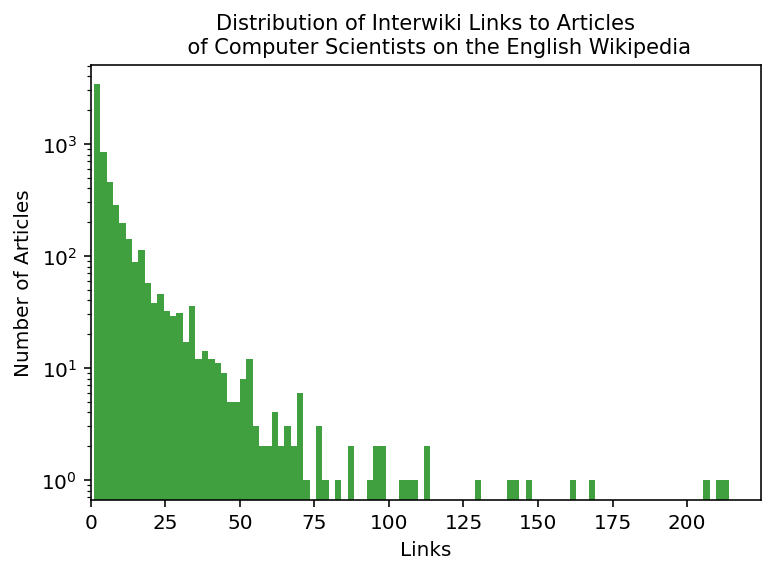

In [64]:
plt.hist(df["links"], bins=100, alpha=0.75, facecolor="g")
plt.xlabel("Links")
plt.xlim(left=0)
plt.ylabel("Number of Articles")
plt.yscale("log")
plt.title("""Distribution of Interwiki Links to Articles
    of Computer Scientists on the English Wikipedia""", fontsize=10.5)
plt.show()

In [47]:
df.sort_values("links", ascending=False).head(10)

,name,url,links
5008,Bill Gates,https://en.wikipedia.org/wiki/Bill_Gates,214
3618,Jimmy Wales,https://en.wikipedia.org/wiki/Jimmy_Wales,210
0,Steven Jobs,https://en.wikipedia.org/wiki/Steve_Jobs,206
3617,Alan Turing,https://en.wikipedia.org/wiki/Alan_Turing,168
3875,Noam Chomsky,https://en.wikipedia.org/wiki/Noam_Chomsky,162
4077,Tim Berners-Lee,https://en.wikipedia.org/wiki/Tim_Berners-Lee,147
4776,Linus Torvalds,https://en.wikipedia.org/wiki/Linus_Torvalds,143
2435,Mark Zuckerberg,https://en.wikipedia.org/wiki/Mark_Zuckerberg,141
247,Julian Assange,https://en.wikipedia.org/wiki/Julian_Assange,129
3303,Edward Snowden,https://en.wikipedia.org/wiki/Edward_Snowden,113


One way of fusing the interwiki links and string similarity statistics is to multiply them together. The relevance of an article to a query can thus be defined as: `relevance = cosine similarity * number of interwiki links`.

In [48]:
# The cosine similarity is calculated
# by subtracting the cosine distance from one.

def rank(neighbors: np.ndarray, cosine_dist: np.ndarray):
    """Rank and enrich the results of the k-NN query"""
    links = df.iloc[neighbors].links
    # Compute the relevance of each neighbor
    relevance = (1 - cosine_dist) * links
    relevance.rename("relevance", inplace=True)
    # Add metadata
    results = df.merge(relevance, left_index=True, right_index=True)
    # Sort the results by relevance
    results = results.sort_values(by="relevance", ascending=False)
    return results

Ranking the retrieved articles by their relevance score yields the following results: 

In [65]:
print("Query: Jeff")
print(" "*15 + "cosine similarity * links = relevance score")

# Query the HNSW index
K = 10
neighbors, cosine_dists = index.knnQueryBatch(query_matrix[2], k=K)[0]

# Rank the results
results = rank(neighbors, cosine_dists)

results = results.join(pd.DataFrame(cosine_dists, index=neighbors, columns=["cosine"]))
for _, result in results.iterrows():
    print(f"{result['name']:<15}{1 - result.cosine:.6f} * {result.links:<2} = {result.relevance:.4f}")

Query: Jeff
               cosine similarity * links = relevance score
Jeff Bezos     0.500000 * 97 = 48.5000
Jeff Skoll     0.500000 * 14 = 7.0000
Jeff Dean      0.534523 * 12 = 6.4143
Jeff Atwood    0.471405 * 12 = 5.6569
Jeff Minter    0.471405 * 10 = 4.7140
Jeff Moss      0.534523 * 7  = 3.7417
Jeff Pulver    0.471405 * 5  = 2.3570
Jeff Black     0.500000 * 2  = 1.0000
Jeff Raikes    0.471405 * 2  = 0.9428
Jeff Bonwick   0.447214 * 1  = 0.4472


The following `search` function retrieves and ranks the top *k* nearest neighbors for any given query.

In [51]:
def search(query: str, k: int):
    """Search for Computer Scientists on Wikipedia"""
    # Vectorize the query
    vectorized_query = vectorizer.transform([query])
    # Search the HNSW graph
    neighbors, cosine = index.knnQueryBatch(vectorized_query, k=k)[0]
    # Rank the results
    results = rank(neighbors, cosine)
    return results

In [52]:
# Example: `Marc` query
search("Marc", k=5)

,name,url,links,relevance
3387,Marc Ewing,https://en.wikipedia.org/wiki/Marc_Ewing,7,3.500000
4224,Marc Snir,https://en.wikipedia.org/wiki/Marc_Snir,3,1.603568
5350,Marc Levoy,https://en.wikipedia.org/wiki/Marc_Levoy,2,1.000000
4117,Marc Vael,https://en.wikipedia.org/wiki/Marc_Vael,1,0.534523
3731,Marc Alexa,https://en.wikipedia.org/wiki/Marc_Alexa,1,0.500000


Real world systems usually retrieve and rank a higher number of results than displayed. For example, the aggregate relevance of the top 5 results for the query "Marc" increases with the number of retrieved nearest neighbors.

In [69]:
search("Marc", k=20).head(5)

,name,url,links,relevance
38,Marc Andreessen,https://en.wikipedia.org/wiki/Marc_Andreessen,31,12.159201
1953,Marcian Hoff,https://en.wikipedia.org/wiki/Marcian_Hoff,22,9.838699
1899,Solomon Marcus,https://en.wikipedia.org/wiki/Solomon_Marcus,17,6.940221
1747,Tom DeMarco,https://en.wikipedia.org/wiki/Tom_DeMarco,14,6.599664
1527,Marco Dorigo,https://en.wikipedia.org/wiki/Marco_Dorigo,8,3.577709


## References

- Principles of Mathematical Analysis (Rudin, 1976)
- Metric space (Wikipedia) [Link](https://en.wikipedia.org/wiki/Metric_space)
- String metric (Wikipedia) [Link](https://en.wikipedia.org/wiki/String_metric)
- Introduction to the Theory of Computation (Sipser, 2013)
- An Introduction to Information Retrieval (Manning et al., 2009)
- Data Structures and Algorithms for Nearest Neighbor Search in General Metric Spaces (P. N. Yianilos, 1993) [PDF](http://algorithmics.lsi.upc.edu/docs/practicas/p311-yianilos.pdf)
- Efficient and robust approximate nearest neighbor search using Hierarchical Navigable Small World graphs (Y. A. Malkov, D. A. Yashunin, 2016) [Arxiv](https://arxiv.org/abs/1603.09320)
- Billion-scale similarity search with GPUs (J. Johnson, M. Douze, H. Jégou, 2019) [Arxiv](https://arxiv.org/abs/1702.08734) / [Github: FAISS library](https://github.com/facebookresearch/faiss)
- ANN-Benchmarks: A Benchmarking Tool for Approximate Nearest Neighbor Algorithms (M. Aumüller, E. Bernhardsson, A. Faithfull, 2019) [Arxiv](https://arxiv.org/abs/1807.05614) / [Github](https://github.com/erikbern/ann-benchmarks)
- Engineering Efficient and Effective Non-Metric Space Library (L. Boytsov, B. Naidan, 2013) [PDF](http://boytsov.info/pubs/sisap2013.pdf) / [Github: NMSLIB](https://github.com/nmslib/nmslib)
- Product Quantization for Nearest Neighbor Search (H. Jégou, M. Douze, C. Schmid,  2011) [HAL-Inria](https://hal.inria.fr/inria-00514462v2)
- Video Google: A Text Retrieval Approach to Object Matching in Videos (J. Sivic, and A. Zisserman, 2003) [PDF](https://www.robots.ox.ac.uk/~vgg/publications/papers/sivic03.pdf)
- Database system concepts, 7th edition (A. Silberschatz, H. F. Korth, S. Sudarshan, 2019)
- A relational model of data for large shared data banks (E. F. Codd, 1970) [PDF](https://www.seas.upenn.edu/~zives/03f/cis550/codd.pdf)
- Relational Algebra (Wikipedia) [Link](https://en.wikipedia.org/wiki/Relational_algebra)
- Wikidata: SPARQL tutorial (Wikidata) [Link](https://www.wikidata.org/wiki/Wikidata:SPARQL_tutorial)